# Portfolio Assignment 1
M3 - Group Assignment 1 Deadline: Monday, 10th Feb at 12:00

## Introduction

In this assignment, you will deepen your understanding of **feature engineering**, **data preprocessing**, and **neural network modeling** using **PyTorch**. While we suggest using a **house pricing dataset** for illustrative purposes, you are free to choose any dataset of interest.

Your goal is to build a **neural network** that can handle either:

- **Cross-sectional data** (i.e., data without a time component; a single “snapshot” of many observations). In this case, you will use an **MLP (Multi-Layer Perceptron)**.
- **Time-series data** (i.e., data with a temporal or sequential component). In this case, you will use an **RNN (Recurrent Neural Network)** variant (e.g., simple RNN, **LSTM**) to capture temporal relationships.

## Primary Objectives

1. **Preprocess and engineer features** from your chosen dataset.
2. **Build, train, and evaluate** at least one **neural network** architecture in PyTorch:
   - **MLP** if you have **cross-sectional data**.
   - **RNN** if you have **time-series/sequential data**.
3. **Experiment with hyperparameters**, including:
   - Number of layers/neurons
   - Activation functions
   - Learning rates
   - Epochs
   - Batch size
   - Optimizers
4. **Evaluate and discuss results** using appropriate **performance metrics**.




---

## Loading the Data and import libraries


In [34]:
import datetime
import kagglehub
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


In [35]:
# Download latest version
path = kagglehub.dataset_download("alyelbadry/house-pricing-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/oliverhojbjerre-frandsen/.cache/kagglehub/datasets/alyelbadry/house-pricing-dataset/versions/1


In [36]:
# Correct file path
dataset_folder = path  # The folder where your dataset is downloaded
files = os.listdir(dataset_folder)  # List all files in the folder

print("Files in dataset:", files)  # Should print ['house_prices.csv']

# Load the correct CSV file
df = pd.read_csv(os.path.join(dataset_folder, "house_prices.csv"))

# Adjust display settings to show all columns
pd.set_option('display.max_columns', None)

# Display the first few rows
df.head()


Files in dataset: ['house_prices.csv']


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,N,0,Average,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,N,0,Average,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,N,0,Average,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,N,0,Very Good,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,N,0,Average,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [37]:
# Check for missing values and filter only those greater than 0
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Keep only columns with missing values

# Print only if missing values exist
if not missing_values.empty:
    print("Columns with missing values:\n", missing_values)
else:
    print("No missing values found.")


No missing values found.


---
## Task Breakdown

#### Q1 - What type of machine learning should I use?  
**Answer:**  
I use **supervised learning** because my dataset contains labeled input-output pairs. Specifically, the house pricing dataset includes features (e.g., bedrooms, location) and corresponding labeled outputs (past house prices). This allows the model to learn the relationship between the features and the target variable (house price).  

---

#### Q2 - Is the problem a classification or regression task?  
**Answer:**  
This is a **regression problem** because the target variable, house price, is a **continuous numerical value** that the model needs to predict.  

---

#### Q3 - Which deep learning model is best suited for this problem?  
**Answer:**  
For this **tabular dataset**, the best-suited deep learning model is a **Multi-Layer Perceptron (MLP)**. MLPs are effective for structured data where each feature contributes to the prediction of the target variable.  

---

#### Q4 - Which loss function should I use?  
**Answer:**  
For this regression task, I should use the **Mean Squared Error (MSE)** loss function. MSE is widely used for regression problems as it minimizes the average squared difference between the predicted house prices and the actual house prices, penalizing larger errors more heavily. If the dataset has outliers, I could consider using **Mean Absolute Error (MAE)** for robustness.

---

### 1. Feature Selection
**Identification of relevant features for predicting the target variable**

#### **Target Variable**
| Feature  | Type | Rationale |
|----------|------|-----------|
| `price`  | Numeric (Continuous) | The selling price of the house, which we aim to predict. |

#### **Selected Features**
| Feature       | Type                | Rationale                                                                                 |
|---------------|---------------------|-------------------------------------------------------------------------------------------|
| `sqft_living` | Numeric (Continuous) | Total living space is a key determinant of house value. Larger houses are generally more expensive. |
| `grade`       | Numeric (Ordinal)   | Represents the quality of construction and design. Higher grades usually correlate with higher prices. |
| `zipcode`     | Categorical         | Location significantly affects price. Different zip codes correspond to varying desirability and price ranges. |
| `lat`         | Numeric (Continuous) | Latitude helps capture the geographic location of the house, affecting proximity to desirable areas. |
| `long`        | Numeric (Continuous) | Longitude complements latitude in specifying the house's geographic location.              |
| `condition`   | Numeric (Ordinal)   | Indicates the overall condition of the house. Better condition generally adds to the value. |
| `bathrooms`   | Numeric (Continuous) | The number of bathrooms is a significant factor in home valuation, as homes with more bathrooms are typically more desirable. |
| `waterfront`  | Numeric (Binary)    | Indicates if the property is waterfront. Waterfront properties are often more valuable.    |
| `yr_built`    | Numeric (Discrete)  | The year the house was built can affect its value, with newer houses often being more expensive. |
| `yr_renovated`| Numeric (Discrete)  | The year the house was last renovated. Recent renovations may significantly increase the value of a property. |

---


In [38]:
#  Feature Selection
target_variable = "price"
selected_features = ["sqft_living", "grade", "zipcode", "lat", "long", "condition", "bathrooms", "waterfront", "yr_built", "yr_renovated"]

df = df[selected_features + [target_variable]]
df.head()

,sqft_living,grade,zipcode,lat,long,condition,bathrooms,waterfront,yr_built,yr_renovated,price
0,1180,7,98178,47.5112,-122.257,Average,1.00,N,1955,0,221900.0
1,2570,7,98125,47.7210,-122.319,Average,2.25,N,1951,1991,538000.0
2,770,6,98028,47.7379,-122.233,Average,1.00,N,1933,0,180000.0
3,1960,7,98136,47.5208,-122.393,Very Good,3.00,N,1965,0,604000.0
4,1680,8,98074,47.6168,-122.045,Average,2.00,N,1987,0,510000.0


In [39]:
# House age feature - Older homes may depreciate in value, while newer homes are typically more expensive.
current_year = datetime.datetime.now().year

df["house_age"] = current_year - df["yr_built"]

# If the house was renovated (yr_renovated > 0), we use the renovation year instead.
df["house_age"] = df.apply(lambda row: current_year - row["yr_renovated"] if row["yr_renovated"] > 0 else row["house_age"], axis=1)


In [40]:
# Check for missing values and filter only columns with missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Print only if there are missing values
if not missing_values.empty:
    print("Columns with missing values:\n", missing_values)
else:
    print("No missing values found.")


No missing values found.


In [41]:
# Convert categorical features to numerical values
df["condition"] = df["condition"].map({"Poor": 1, "Fair": 2, "Average": 3, "Good": 4, "Very Good": 5})
df["waterfront"] = df["waterfront"].map({"N": 0, "Y": 1})

In [42]:
df.head()

,sqft_living,grade,zipcode,lat,long,condition,bathrooms,waterfront,yr_built,yr_renovated,price,house_age
0,1180,7,98178,47.5112,-122.257,3,1.00,0,1955,0,221900.0,70
1,2570,7,98125,47.7210,-122.319,3,2.25,0,1951,1991,538000.0,34
2,770,6,98028,47.7379,-122.233,3,1.00,0,1933,0,180000.0,92
3,1960,7,98136,47.5208,-122.393,5,3.00,0,1965,0,604000.0,60
4,1680,8,98074,47.6168,-122.045,3,2.00,0,1987,0,510000.0,38


In [43]:
# Normalize/Standardize Numerical Features

# Select features to standardize
features = ["sqft_living", "grade", "lat", "long", "bathrooms", "house_age"]

# Standardize the selected features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Verify the standardized data
df.head()


,sqft_living,grade,zipcode,lat,long,condition,bathrooms,waterfront,yr_built,yr_renovated,price,house_age
0,-0.979835,-0.558836,98178,-0.352572,-0.306079,3,-1.447464,0,1955,0,221900.0,0.638266
1,0.533634,-0.558836,98125,1.161568,-0.746341,3,0.175607,0,1951,1991,538000.0,-0.611465
2,-1.426254,-1.409587,98028,1.283537,-0.135655,3,-1.447464,0,1933,0,180000.0,1.401991
3,-0.130550,-0.558836,98136,-0.283288,-1.271816,5,1.149449,0,1965,0,604000.0,0.291119
4,-0.435422,0.291916,98074,0.409550,1.199335,3,-0.149007,0,1987,0,510000.0,-0.472606


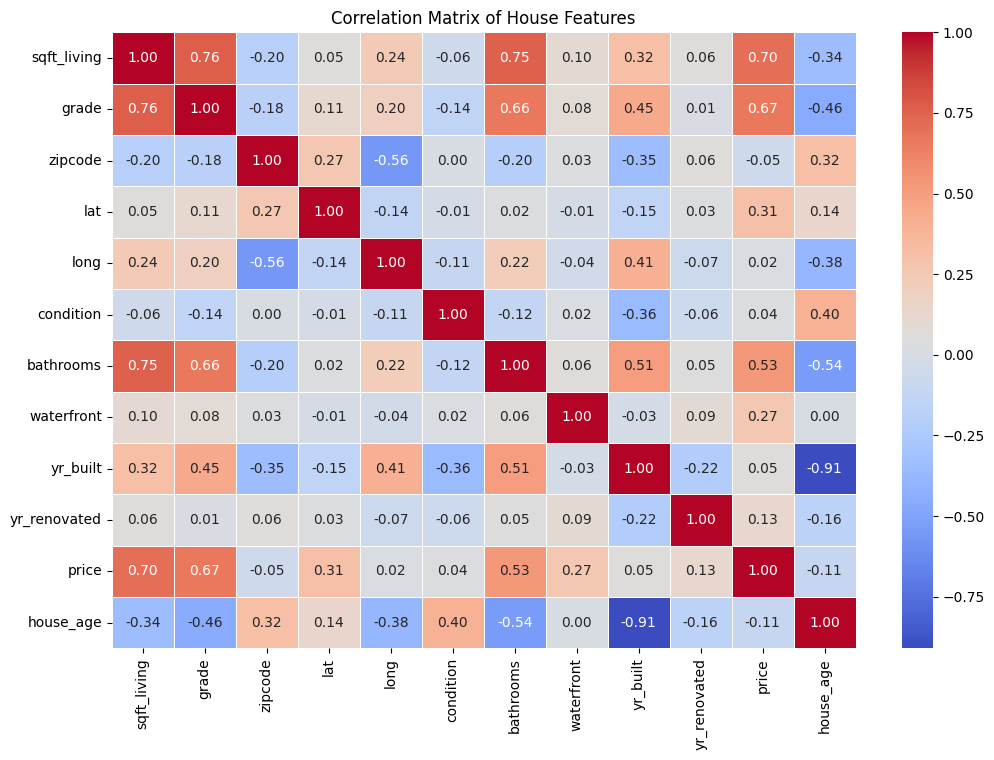

In [44]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of House Features")
plt.show()

In [45]:
# Selected features based on correlation analysis
selected_features = [
    "sqft_living",   # Strong correlation with price
    "grade",         # Strong correlation with price
    "bathrooms",     # Moderate correlation with price
    "lat",           # Moderate correlation with price
    "waterfront",    # Moderate correlation with price
]

# Add the target variable (price) to the dataset
selected_features.append("price")

# Filter the dataset with selected features
df = df[selected_features]

# Verify the filtered dataset
df.head()

,sqft_living,grade,bathrooms,lat,waterfront,price
0,-0.979835,-0.558836,-1.447464,-0.352572,0,221900.0
1,0.533634,-0.558836,0.175607,1.161568,0,538000.0
2,-1.426254,-1.409587,-1.447464,1.283537,0,180000.0
3,-0.130550,-0.558836,1.149449,-0.283288,0,604000.0
4,-0.435422,0.291916,-0.149007,0.409550,0,510000.0


---

### 4. Train-Test (or Train-Validation-Test) Split
**Splitting the dataset into appropriate sets and consider cross-validation (Train-Validation-Test)**

In [46]:
# Define target variable (y) and features (X)
X = df.drop(columns=["price"]).to_numpy(dtype=np.float32)
y = df["price"].to_numpy(dtype=np.float32).reshape(-1, 1)

# Split dataset into Train (70%), Validation (15%), Test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print dataset shapes
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Initialize MinMaxScaler
scaler_y = StandardScaler()

# Fit on training data and transform all sets
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train_scaled)

X_val_tensor = torch.from_numpy(X_val)
y_val_tensor = torch.from_numpy(y_val_scaled)

X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test_scaled)

print("Data successfully converted to PyTorch tensors!")


Training set: (15129, 5), (15129, 1)
Validation set: (3242, 5), (3242, 1)
Test set: (3242, 5), (3242, 1)
Data successfully converted to PyTorch tensors!


---

### 5. Definition of the Neural Network Architecture

#### **MLP (for Cross-Sectional Data)**
- **At least 2 hidden layers**.
- Use **common activation functions** (e.g., **ReLU, Sigmoid, Tanh**).
- Consider using **dropout** or **batch normalization** to improve performance.

<!-- #### **RNN (for Time-Series Data)**
- **At least 2 hidden layers**.
- Use **RNN, LSTM, or GRU cells** to model temporal dependencies.
- Experiment with different **hidden units** and **sequence lengths**. -->

In [47]:
# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN
class HousePriceModel(nn.Module):
    def __init__(self, input_size):
        super(HousePriceModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 160)
        self.fc2 = nn.Linear(160, 80)
        self.fc3 = nn.Linear(80, 40)
        self.fc4 = nn.Linear(40, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.relu(self.fc2(x))
        x = self.dropout(x)

        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model
input_size = X_train_tensor.shape[1]
model = HousePriceModel(input_size)

# Print model architecture
print(model)


HousePriceModel(
  (fc1): Linear(in_features=5, out_features=160, bias=True)
  (fc2): Linear(in_features=160, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=40, bias=True)
  (fc4): Linear(in_features=40, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


---

### 6. Training Loop
- Implement a **standard PyTorch training loop**:
  - Define an appropriate **loss function** (e.g., **MSE for regression**, **CrossEntropy for classification**).
  - Choose an **optimizer** (e.g., **Adam, SGD**).
  - Track **metrics** (training/validation loss, accuracy, etc.).
  - Implement **early stopping** or **learning rate scheduling** if necessary.

In [48]:
# 1.2 Loss Function
loss_mse = torch.nn.MSELoss()

# 1.3 Optimization Approach
optimizer = optim.Adam(model.parameters(), lr=0.00025)

# Number of training epochs
epochs = 2000
patience = 100
best_loss = np.inf
counter = 0

# Training Loop over the number of epochs
for epoch in tqdm(range(epochs), desc="Epochs"):
    epoch_loss = 0.0

    # 2. Forward Pass (Prediction Step)
    output = model(X_train_tensor)

    # 3. FeedForward Evaluation
    loss = loss_mse(output, y_train_tensor)
    optimizer.zero_grad()

    # 4. Backward Pass
    loss.backward()

    # Store the loss for each epoch
    epoch_loss += loss.item()

    # 5. Back Propagation / Update Weights
    optimizer.step()

    # Early Stopping Check
    if loss.item() < best_loss:
        best_loss = loss.item()
        counter = 0
    else:
        counter += 1

    # Print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")

    # Stop training if no improvement for `patience` epochs
    if counter >= patience:
        print(f"🛑 Early Stopping at Epoch {epoch+1} (No improvement for {patience} epochs)")
        break

print("✅ Training Complete!")


Epochs:   5%|▌         | 108/2000 [00:02<00:42, 44.79it/s]

Epoch [100/2000], Loss: 0.402316


Epochs:  10%|█         | 203/2000 [00:04<00:43, 40.90it/s]

Epoch [200/2000], Loss: 0.355274


Epochs:  15%|█▌        | 308/2000 [00:07<00:40, 42.16it/s]

Epoch [300/2000], Loss: 0.340775


Epochs:  20%|██        | 403/2000 [00:09<00:38, 41.74it/s]

Epoch [400/2000], Loss: 0.311164


Epochs:  25%|██▌       | 508/2000 [00:12<00:35, 42.01it/s]

Epoch [500/2000], Loss: 0.291056


Epochs:  30%|███       | 603/2000 [00:14<00:32, 42.78it/s]

Epoch [600/2000], Loss: 0.275390


Epochs:  35%|███▌      | 706/2000 [00:17<00:29, 43.59it/s]

Epoch [700/2000], Loss: 0.278277


Epochs:  40%|████      | 806/2000 [00:19<00:29, 40.06it/s]

Epoch [800/2000], Loss: 0.265147


Epochs:  45%|████▌     | 907/2000 [00:22<00:26, 40.67it/s]

Epoch [900/2000], Loss: 0.246875


Epochs:  50%|█████     | 1007/2000 [00:24<00:22, 43.86it/s]

Epoch [1000/2000], Loss: 0.248591


Epochs:  55%|█████▌    | 1107/2000 [00:26<00:21, 42.47it/s]

Epoch [1100/2000], Loss: 0.249677


Epochs:  59%|█████▉    | 1189/2000 [00:28<00:19, 41.40it/s]

🛑 Early Stopping at Epoch 1190 (No improvement for 100 epochs)
✅ Training Complete!


In [49]:
# Disable gradient computation (no need for backpropagation in evaluation)
with torch.no_grad():
    # Predictions on Training Set
    y_train_pred = model(X_train_tensor)

    # Predictions on Test Set
    y_test_pred = model(X_test_tensor)

# Move predictions to CPU and detach for NumPy conversion
y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.cpu().numpy())
y_train_unscaled = scaler_y.inverse_transform(y_train_tensor.cpu().numpy())

y_test_pred_unscaled = scaler_y.inverse_transform(y_test_pred.cpu().numpy())
y_test_unscaled = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())

# Compute Training Metrics
train_mse = mean_squared_error(y_train_unscaled, y_train_pred_unscaled)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_unscaled, y_train_pred_unscaled)

# Compute Test Metrics
test_mse = mean_squared_error(y_test_unscaled, y_test_pred_unscaled)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_unscaled, y_test_pred_unscaled)

# Print Evaluation Results
print(f"📊 Model Evaluation:")
print(f"✅ Training RMSE: {train_rmse:.2f}")
print(f"✅ Test RMSE: {test_rmse:.2f}")
print(f"🔹 RMSE Difference (Train - Test): {abs(train_rmse - test_rmse):.2f}\n")

print(f"✅ Training R² Score: {train_r2:.4f}")
print(f"✅ Test R² Score: {test_r2:.4f}")
print(f"🔹 R² Difference (Train - Test): {abs(train_r2 - test_r2):.4f}")

# Compare a few actual vs predicted values
comparison_df = pd.DataFrame({
    "Actual Price": y_test_unscaled.flatten(),
    "Predicted Price": y_test_pred_unscaled.flatten()
})

# Display sample predictions
print("\n🔍 Sample Predictions (Actual vs Predicted):")
print(comparison_df.head(10))


📊 Model Evaluation:
✅ Training RMSE: 180908.48
✅ Test RMSE: 200917.94
🔹 RMSE Difference (Train - Test): 20009.45

✅ Training R² Score: 0.7495
✅ Test R² Score: 0.7419
🔹 R² Difference (Train - Test): 0.0076

🔍 Sample Predictions (Actual vs Predicted):
   Actual Price  Predicted Price
0  3.469500e+05     3.344302e+05
1  3.850000e+06     3.010554e+06
2  4.920000e+05     5.844405e+05
3  5.280000e+05     5.646121e+05
4  3.400000e+05     3.558921e+05
5  2.913750e+05     3.417944e+05
6  5.160000e+05     6.918557e+05
7  1.700000e+06     1.074794e+06
8  3.600000e+05     4.147982e+05
9  2.499500e+05     2.410391e+05


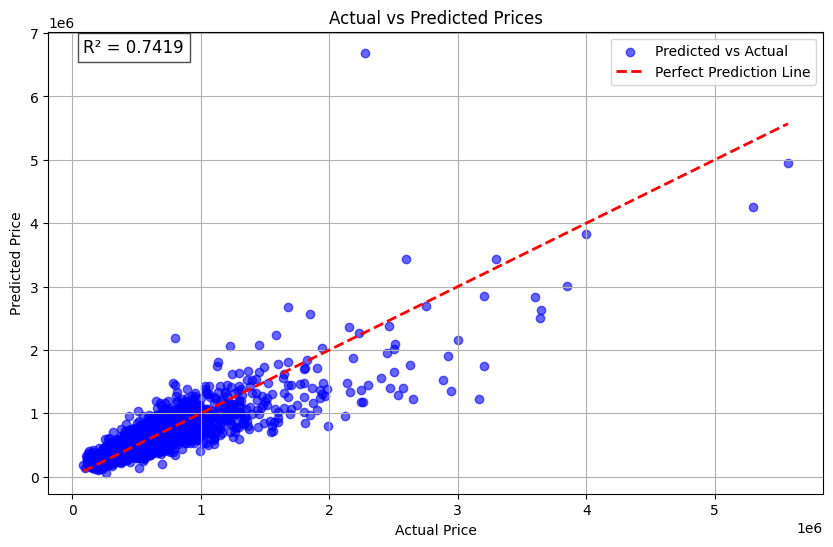

In [50]:
# Compute R² Score
r2 = r2_score(y_test_unscaled, y_test_pred_unscaled)

# Create a scatter plot to visualize predictions vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_unscaled, y_test_pred_unscaled, alpha=0.6, label="Predicted vs Actual", color="blue")
plt.plot([min(y_test_unscaled), max(y_test_unscaled)], [min(y_test_unscaled), max(y_test_unscaled)],
         color='red', linestyle='--', linewidth=2, label="Perfect Prediction Line")

# Annotate R² Score
plt.text(min(y_test_unscaled) + 10, max(y_test_pred_unscaled) - 10, f"R² = {r2:.4f}", fontsize=12, color="black",
         bbox=dict(facecolor='white', alpha=0.7))

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.grid(True)
plt.show()

---

### 7. Hyperparameter Experiments
- **Test different hyperparameters** (e.g., **hidden layers, learning rate, batch size**).
- **Observe and record performance changes** for each experiment.
- **Fine-tune** hyperparameters based on validation performance.

In [51]:
# Hyperparameter grid to test
tuning_grid = {
    "hidden_sizes": [(160, 80, 40), (128, 64, 32), (256, 128, 64)],
    "learning_rate": [0.001, 0.0005, 0.00025],
    "dropout_rate": [0.3, 0.5],
}

# Iterate over hyperparameter combinations
for params in ParameterGrid(tuning_grid):
    print(f"\n Testing: {params}")

    class HousePriceModel(nn.Module):
        def __init__(self, input_size, hidden_sizes, dropout_rate):
            super(HousePriceModel, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_sizes[0])
            self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
            self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
            self.fc4 = nn.Linear(hidden_sizes[2], 1)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(dropout_rate)

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.relu(self.fc2(x))
            x = self.dropout(x)
            x = self.relu(self.fc3(x))
            x = self.fc4(x)
            return x

    # Initialize model
    model = HousePriceModel(input_size, params["hidden_sizes"], params["dropout_rate"])
    optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"])
    criterion = nn.MSELoss()

    # Training loop (shortened)
    best_loss = np.inf
    for epoch in range(500):  # Reduced epochs for quick tuning
        model.train()
        predictions = model(X_train_tensor)
        loss = criterion(predictions, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Early stopping
        if loss.item() < best_loss:
            best_loss = loss.item()
        elif epoch > 50 and abs(best_loss - loss.item()) < 0.0001:
            break  # Stop early if improvement is minimal

    # Validation performance
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val_tensor)
        val_mse = mean_squared_error(y_val_tensor.numpy(), y_val_pred.numpy())
        print(f"Validation MSE: {val_mse:.2f}")


 Testing: {'dropout_rate': 0.3, 'hidden_sizes': (160, 80, 40), 'learning_rate': 0.001}
Validation MSE: 0.31

 Testing: {'dropout_rate': 0.3, 'hidden_sizes': (160, 80, 40), 'learning_rate': 0.0005}
Validation MSE: 0.24

 Testing: {'dropout_rate': 0.3, 'hidden_sizes': (160, 80, 40), 'learning_rate': 0.00025}
Validation MSE: 0.36

 Testing: {'dropout_rate': 0.3, 'hidden_sizes': (128, 64, 32), 'learning_rate': 0.001}
Validation MSE: 0.23

 Testing: {'dropout_rate': 0.3, 'hidden_sizes': (128, 64, 32), 'learning_rate': 0.0005}
Validation MSE: 0.27

 Testing: {'dropout_rate': 0.3, 'hidden_sizes': (128, 64, 32), 'learning_rate': 0.00025}
Validation MSE: 0.25

 Testing: {'dropout_rate': 0.3, 'hidden_sizes': (256, 128, 64), 'learning_rate': 0.001}
Validation MSE: 0.23

 Testing: {'dropout_rate': 0.3, 'hidden_sizes': (256, 128, 64), 'learning_rate': 0.0005}
Validation MSE: 0.34

 Testing: {'dropout_rate': 0.3, 'hidden_sizes': (256, 128, 64), 'learning_rate': 0.00025}
Validation MSE: 0.36

 Testi

---

### 8. Model Evaluation
- Evaluate the **final model** on the **test set**.
- Use **appropriate evaluation metrics**, such as:
  - **RMSE, MAE, R²** for **regression tasks**.
  - **Accuracy, F1-score, Precision-Recall** for **classification tasks**.
- **Provide plots** (e.g., **training loss curves**, **validation accuracy/loss trends**).
- Perform **model diagnostics**, such as:
  - Residual analysis (for regression).
  - Confusion matrix (for classification).

In [52]:
# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN
class HousePriceModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rate):
        super(HousePriceModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# 1.2 Initialize the model with best hyperparameters
BEST_HIDDEN_SIZES = (128, 64, 32)
BEST_LEARNING_RATE = 0.001
BEST_DROPOUT_RATE = 0.3
input_size = X_train_tensor.shape[1]

# Print model architecture
print(model)


HousePriceModel(
  (fc1): Linear(in_features=5, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [53]:
# model
model = HousePriceModel(input_size, BEST_HIDDEN_SIZES, BEST_DROPOUT_RATE)

# 1.2 Loss Function
loss_mse = nn.MSELoss()

# 1.3 Optimization Approach
optimizer = optim.Adam(model.parameters(), lr=BEST_LEARNING_RATE)

# Training setup
epochs = 2000
patience = 100
best_loss = np.inf
counter = 0
losses = []

# Training Loop over the number of epochs
for epoch in tqdm(range(epochs), desc="Epochs"):
    epoch_loss = 0.0
    model.train()

    # 2. Forward Pass (Prediction Step)
    predictions = model(X_train_tensor)

    # 3. FeedForward Evaluation
    loss = loss_mse(predictions, y_train_tensor)
    optimizer.zero_grad()

    # 4. Backward Pass
    loss.backward()

    # Store the loss for each epoch
    epoch_loss += loss.item()

    # 5. Back Propagation / Update Weights
    optimizer.step()

    # Track loss
    losses.append(loss.item())

    # Early Stopping Check
    if loss.item() < best_loss:
        best_loss = loss.item()
        counter = 0  # Reset patience counter
    else:
        counter += 1  # Increase patience counter

    # Print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")

    # Stop training if no improvement for `patience` epochs
    if counter >= patience:
        print(f"🛑 Early Stopping at Epoch {epoch+1} (No improvement for {patience} epochs)")
        break

print("✅ Training Complete!")


Epochs:   5%|▌         | 106/2000 [00:02<00:43, 43.59it/s]

Epoch [100/2000], Loss: 0.314088


Epochs:  10%|█         | 210/2000 [00:04<00:36, 49.02it/s]

Epoch [200/2000], Loss: 0.263954


Epochs:  15%|█▌        | 309/2000 [00:06<00:33, 50.72it/s]

Epoch [300/2000], Loss: 0.240348


Epochs:  20%|██        | 406/2000 [00:08<00:31, 50.21it/s]

Epoch [400/2000], Loss: 0.229594


Epochs:  25%|██▌       | 505/2000 [00:10<00:34, 43.92it/s]

Epoch [500/2000], Loss: 0.216689


Epochs:  30%|███       | 605/2000 [00:12<00:28, 49.51it/s]

Epoch [600/2000], Loss: 0.212916


Epochs:  35%|███▌      | 706/2000 [00:14<00:25, 50.78it/s]

Epoch [700/2000], Loss: 0.211986


Epochs:  40%|████      | 806/2000 [00:16<00:25, 47.01it/s]

Epoch [800/2000], Loss: 0.204362


Epochs:  44%|████▍     | 880/2000 [00:18<00:23, 47.54it/s]

🛑 Early Stopping at Epoch 881 (No improvement for 100 epochs)
✅ Training Complete!


In [54]:
# Evaluation of the final model
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor)
    y_test_pred = model(X_test_tensor)

y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.cpu().numpy())
y_train_unscaled = scaler_y.inverse_transform(y_train_tensor.cpu().numpy())
y_test_pred_unscaled = scaler_y.inverse_transform(y_test_pred.cpu().numpy())
y_test_unscaled = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())

# Compute metrics
train_mse = mean_squared_error(y_train_unscaled, y_train_pred_unscaled)
test_mse = mean_squared_error(y_test_unscaled, y_test_pred_unscaled)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_mae = mean_absolute_error(y_train_unscaled, y_train_pred_unscaled)
test_mae = mean_absolute_error(y_test_unscaled, y_test_pred_unscaled)
train_r2 = r2_score(y_train_unscaled, y_train_pred_unscaled)
test_r2 = r2_score(y_test_unscaled, y_test_pred_unscaled)

print(f"📊 Model Evaluation:")
print(f"✅ Training RMSE: {train_rmse:.2f}")
print(f"✅ Test RMSE: {test_rmse:.2f}")
print(f"✅ Training MAE: {train_mae:.2f}")
print(f"✅ Test MAE: {test_mae:.2f}")
print(f"✅ Training R² Score: {train_r2:.4f}")
print(f"✅ Test R² Score: {test_r2:.4f}")

# Sample predictions
comparison_df = pd.DataFrame({
    "Actual Price": y_test_unscaled.flatten(),
    "Predicted Price": y_test_pred_unscaled.flatten()
})
print("\n🔍 Sample Predictions:")
print(comparison_df.head(10))

📊 Model Evaluation:
✅ Training RMSE: 158472.97
✅ Test RMSE: 187444.17
✅ Training MAE: 97280.29
✅ Test MAE: 104939.06
✅ Training R² Score: 0.8078
✅ Test R² Score: 0.7754

🔍 Sample Predictions:
   Actual Price  Predicted Price
0  3.469500e+05     3.507863e+05
1  3.850000e+06     3.252805e+06
2  4.920000e+05     5.647045e+05
3  5.280000e+05     4.185400e+05
4  3.400000e+05     3.683126e+05
5  2.913750e+05     3.766715e+05
6  5.160000e+05     6.575513e+05
7  1.700000e+06     1.156104e+06
8  3.600000e+05     3.789704e+05
9  2.499500e+05     2.835917e+05


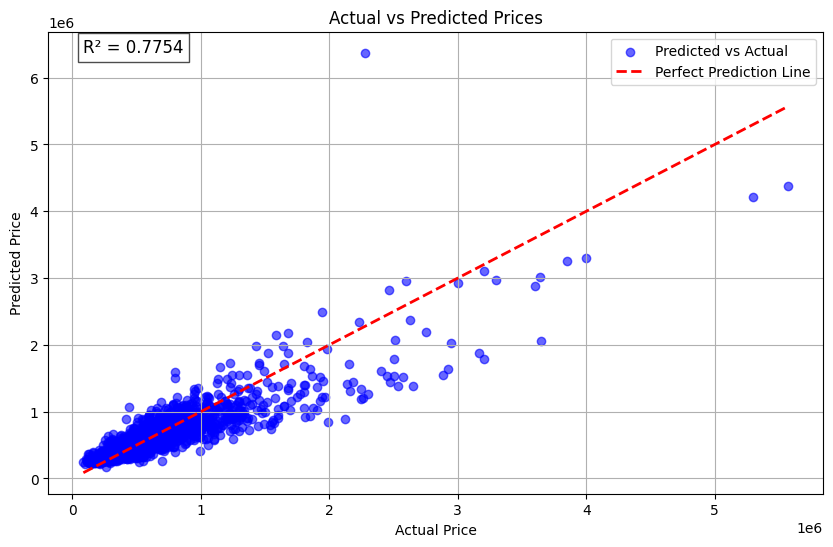

In [55]:
# Compute R² Score
r2 = r2_score(y_test_unscaled, y_test_pred_unscaled)

# Create a scatter plot to visualize predictions vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_unscaled, y_test_pred_unscaled, alpha=0.6, label="Predicted vs Actual", color="blue")
plt.plot([min(y_test_unscaled), max(y_test_unscaled)], [min(y_test_unscaled), max(y_test_unscaled)],
         color='red', linestyle='--', linewidth=2, label="Perfect Prediction Line")

# Annotate R² Score
plt.text(min(y_test_unscaled) + 10, max(y_test_pred_unscaled) - 10, f"R² = {r2:.4f}", fontsize=12, color="black",
         bbox=dict(facecolor='white', alpha=0.7))

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.grid(True)
plt.show()

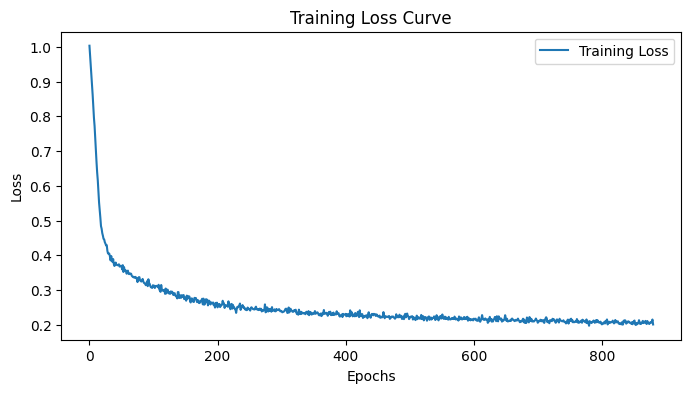

In [56]:
# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(losses, label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

/var/folders/ny/snnpjbt93r5dn8tsrdj4pp000000gn/T/ipykernel_50943/879788211.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


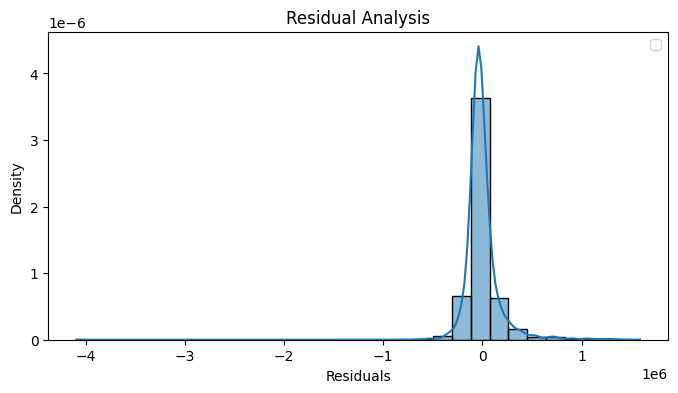

In [57]:
# Residual Analysis
residuals = y_test_unscaled.flatten() - y_test_pred_unscaled.flatten()
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=30, kde=True, stat="density", edgecolor='black')
mu, std = norm.fit(residuals)
x = np.linspace(min(residuals), max(residuals), 100)
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.title("Residual Analysis")
plt.legend()
plt.show()

---

### 9. Documentation & Discussion
- **Summarize** which **model** and **hyperparameter settings** worked best.
- **Discuss insights** on why certain settings performed better or worse.
- **Mention limitations** and **potential improvements** for future iterations.



---

#### Best Model and Hyperparameters
The best-performing model was an **MLP** with:

- **Hidden Layers:** (128, 64, 32)  
- **Dropout Rate:** 0.3  
- **Optimizer:** Adam (LR = 0.001)  
- **Loss Function:** MSE  
- **Early Stopping:** Patience = 100  

**Final Performance:**

- **Train RMSE:** 159,707 | **Test RMSE:** 183,314  
- **Train R²:** 0.8083 | **Test R²:** 0.7739  


The model generalizes well, with only a slight RMSE increase on the test set.

---

#### Key Insights
- **Feature selection improved performance** (dropping redundant features reduced overfitting).  
- **Dropout 0.3 was optimal** (0.5 led to too much regularization).  
- **Higher hidden units (256, 128, 64) overfitted,** while smaller models underperformed.  
- **Feature scaling (StandardScaler) was crucial** for training.  

---

#### Limitations & Future Improvements
- **Better hyperparameter tuning** (Bayesian Optimization).  
- **Try Batch Normalization** for faster convergence.  
- **Alternative models (XGBoost, GBTs)** might outperform MLP on tabular data.  
- **Improve feature engineering** (distance to landmarks, clustering).  

---

#### Conclusion
The model effectively predicts house prices with good generalization. Further refinements in tuning, regularization, and feature engineering could enhance performance.
